In [9]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage, ToolMessage
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults

In [11]:
tool = TavilySearchResults(tavily_api_key = "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", max_results=2)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [13]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [29]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [30]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOllama(model="qwen2.5")
abot = Agent(model, [tool], system=prompt)

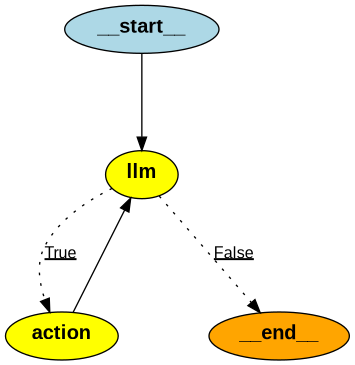

In [31]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [36]:
messages = [HumanMessage(content="What is the current weather in Lahore Pakistan?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Lahore Pakistan'}, 'id': 'e43eaa18-9b5d-45a1-8c9e-e6b849757475', 'type': 'tool_call'}
Back to the model!


In [37]:
result['messages'][-1].content

"The current weather in Lahore, Pakistan as of Wednesday, June 11, 2025 at 12:00 PM UTC is:\n\n- Temperature: 109°F (43°C)\n- Dew Point: 61°F (16°C) - humid\n- Relative Humidity: 21%\n- Wind: 6.9 mph from the west\n- Cloud Cover: Not specified, but it's currently sunny\n\nPlease note that this data is specific to a point in time and place at Allama Iqbal International Airport. For more up-to-date information or conditions closer to your location within Lahore, you might want to check local weather services."

In [41]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOllama(model="qwen2.5")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner and location'}, 'id': 'ea9fe8e0-9084-44b8-b8b1-d08cfc13baa9', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri'}, 'id': '1e03be3e-69ce-4ec3-bf8d-c047467175f1', 'type': 'tool_call'}
Back to the model!


In [42]:
print(result['messages'][-1].content)

From the search results:

1. **Super Bowl Winner in 2024:** The Kansas City Chiefs won Super Bowl LVIII.
2. **Headquarters State of the Winning Team (Kansas City Chiefs):** The headquarters of the Kansas City Chiefs is located in Missouri.
3. **GDP of Missouri (2023):** According to estimates from the U.S. Bureau of Economic Analysis, Missouri ranked 21st nationally in Gross Domestic Product (GSP) at $348.49 billion in inflation-adjusted (chained 2017) dollars.

Thus, the answers are:

- The Kansas City Chiefs won Super Bowl 2024.
- The winning team's headquarters is located in Missouri.
- The GDP of Missouri for 2023 was $348.49 billion.
